# **Calculating Correlations**

## Notebook Setup

First, import all necessary packages

In [2]:
!pip install pymannkendall xarray cfgrib contextily cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 116.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 99.7 MB/s eta 0:00:00


In [13]:
import ee
import geemap
import geemap.colormaps as cm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import math
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.sparse import diags, eye
from scipy.sparse.linalg import spsolve
from scipy.signal import savgol_filter
import pymannkendall as mk
import json
import os
from tqdm.notebook import tqdm
import geopandas as gpd
from glob import glob
from shapely.geometry import shape
from matplotlib.colors import TwoSlopeNorm
import contextily as cx  # for adding basemaps
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize
from matplotlib import cm
from shapely.geometry import shape, mapping
import xarray as xr
from geemap import ee_export_vector
from scipy.stats import spearmanr

Set user defined variables

In [ ]:
setup_path = '/content/drive/MyDrive/final_project_code/src/analysis_setup.txt'

config = {}

with open(setup_path, 'r') as f:

    for line in f:
        line = line.strip()
        if not line or line.startswith('#'):
            continue
        key, value = line.split('=', 1)
        key = key.strip()
        value = value.strip().strip("'").strip('"')
        config[key] = value

# Convert known integers
config['start_year'] = int(config['start_year'])
config['end_year'] = int(config['end_year'])

# Create the variables from the config dictionary
ee_username = config['ee_username']
study_area = config['study_area']
start_date = config['start_date']
end_date = config['end_date']
start_year = config['start_year']
end_year = config['end_year']
raw_pixel_evi_data = config['raw_pixel_evi_data']
processed_pixel_evi_data = config['processed_pixel_evi_data']
greening_strip = config['greening_strip']
kg_zones = config['kg_zones']
correlation_data = config['correlation_data']
geo_tiff_data = config['geo_tiff_data']

# Print them for reference and verification
print(ee_username, type(ee_username))
print(study_area, type(study_area))
print(start_date, type(start_date))
print(end_date, type(end_date))
print(start_year, type(start_year))
print(end_year, type(end_year))
print(raw_pixel_evi_data, type(raw_pixel_evi_data))
print(processed_pixel_evi_data, type(processed_pixel_evi_data))
print(greening_strip, type(greening_strip))
print(kg_zones, type(kg_zones))
print(correlation_data, type(correlation_data))
print(geo_tiff_data, type(geo_tiff_data))

ee-pantonopoulos517 <class 'str'>
projects/ee-pantonopoulos517/assets/Peru_Chile_ROI-2 <class 'str'>
2000-01-01 <class 'str'>
2024-12-31 <class 'str'>
2000 <class 'int'>
2024 <class 'int'>
/content/drive/MyDrive/final_raw_data <class 'str'>
/content/drive/MyDrive/final_processed_data <class 'str'>
projects/ee-pantonopoulos517/assets/final_greening_strip <class 'str'>
projects/ee-pantonopoulos517/assets/koppen_geiger_0p00833333 <class 'str'>
/content/drive/MyDrive/correlation_data <class 'str'>
/content/drive/MyDrive/geo_tiff_data <class 'str'>


Initialise Google Earth Engine

In [5]:
try:
    ee.Initialize(project=ee_username)
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project=ee_username)

## Correlation Calculations Pipeline

We need to find the correlations between the greening strip (GS), BWh, BWk, BSk, and the precipitation, Sea Surface Temperature (SST), and CO$_{2}$ concentration climate drivers.

First, exclude land cover changes using LCCS

Get the LCCS .tif file

In [ ]:
# Define ROI
roi = ee.FeatureCollection(study_area) \
         .geometry() \
         .bounds()

# Load land cover image for 2019 using LCCS classification
landcover = ee.ImageCollection("COPERNICUS/Landcover/100m/Proba-V-C3/Global") \
               .filterDate('2019-01-01', '2019-12-31') \
               .first() \
               .select('discrete_classification')

# Export the image as a GeoTIFF
export_task = ee.batch.Export.image.toDrive(
    image=landcover.clip(roi),
    description='LCCS_Landcover_2019',
    folder='correlation_data',
    scale=250,
    region=roi.getInfo()['coordinates'],
    crs='EPSG:4326',
    fileFormat='GeoTIFF',
    maxPixels=1e13
)

# Start the export task
export_task.start()

This .tif file is used to mask agriculture, urban, and water areas as follows

In [ ]:
# Load EVI .json files
json_files = glob(processed_pixel_evi_data+"/*.json")
all_features = []

for f in json_files:
    with open(f, 'r') as file:
        data = json.load(file)
        for feat in data:
            geom = shape(feat['geometry'])
            props = feat['properties']
            props['geometry'] = geom
            all_features.append(props)

In [ ]:
gdf = gpd.GeoDataFrame(all_features, crs="EPSG:4326")
gdf["delta_evi"] = gdf["delta_evi"].clip(lower=-10, upper=60)

# Load land cover raster and sample values 
lulc_tif = correlation_data+"/LCCS_Landcover_2019.tif"  # From previous Earth Engine code
exclude_lulc_classes = [40, 50, 80]  # Urban, agricultural cropland, and water

with rasterio.open(lulc_tif) as src:
    if gdf.crs != src.crs:
        gdf = gdf.to_crs(src.crs)
    coords = [(pt.x, pt.y) for pt in gdf.geometry]
    lulc_vals = [val[0] for val in src.sample(coords)]

gdf["lulc"] = lulc_vals
gdf = gdf[~gdf["lulc"].isin(exclude_lulc_classes)]  # Mask out excluded classes

In [ ]:
pixel_size = 0.00225  # approx 250m resolution at equator
minx, miny, maxx, maxy = gdf.total_bounds # get bounds
width = int((maxx - minx) / pixel_size) #  determine the raster size in pixels
height = int((maxy - miny) / pixel_size)
transform = from_origin(minx, maxy, pixel_size, pixel_size) # specify how raster pixels map to geographic coordinates

shapes = ((geom, val) for geom, val in zip(gdf.geometry, gdf["delta_evi"]))
evi_raster = rasterize(
    shapes=shapes,
    out_shape=(height, width),
    transform=transform,
    fill=np.nan,
    dtype="float32",
    all_touched=True
)

masked_evi = np.ma.masked_invalid(evi_raster)  # Mask NaNs
norm = TwoSlopeNorm(vmin=-10, vcenter=0, vmax=60)
cmap = cm.get_cmap("RdYlGn")
rgba = cmap(norm(masked_evi))

# Convert to RGB
rgb = (rgba[:, :, :3] * 255).astype("uint8")

# Save RGB GeoTIFF
rgb_output = geo_tiff_data+"/lulc_masked_delta_evi_heatmap.tif"
with rasterio.open(
    rgb_output,
    "w",
    driver="GTiff",
    height=rgb.shape[0],
    width=rgb.shape[1],
    count=3,
    dtype="uint8",
    crs="EPSG:4326",
    transform=transform
) as dst:
    dst.write(rgb[:, :, 0], 1)  # Red
    dst.write(rgb[:, :, 1], 2)  # Green
    dst.write(rgb[:, :, 2], 3)  # Blue

print(f"Saved RGB GeoTIFF to: {rgb_output}")

<ipython-input-110-4e935576efb6>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("RdYlGn")


Saved RGB GeoTIFF to: /content/drive/MyDrive/data/geo_tiffs/lulc_masked_final.tif


This .tif is imported into QGIS and the GS is manually outlined by adding a polygon layer and tracing the strip. Please see the demonstration gifs in $\texttt{~/demos}$ for how to do this.


Let's visualise the GS over the heatmap

In [ ]:
greening_strip = ee.FeatureCollection(greening_strip)
path = "/content/drive/MyDrive/greening_strip.geojson"
ee_export_vector(greening_strip, path)

Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/greening_strip.geojson


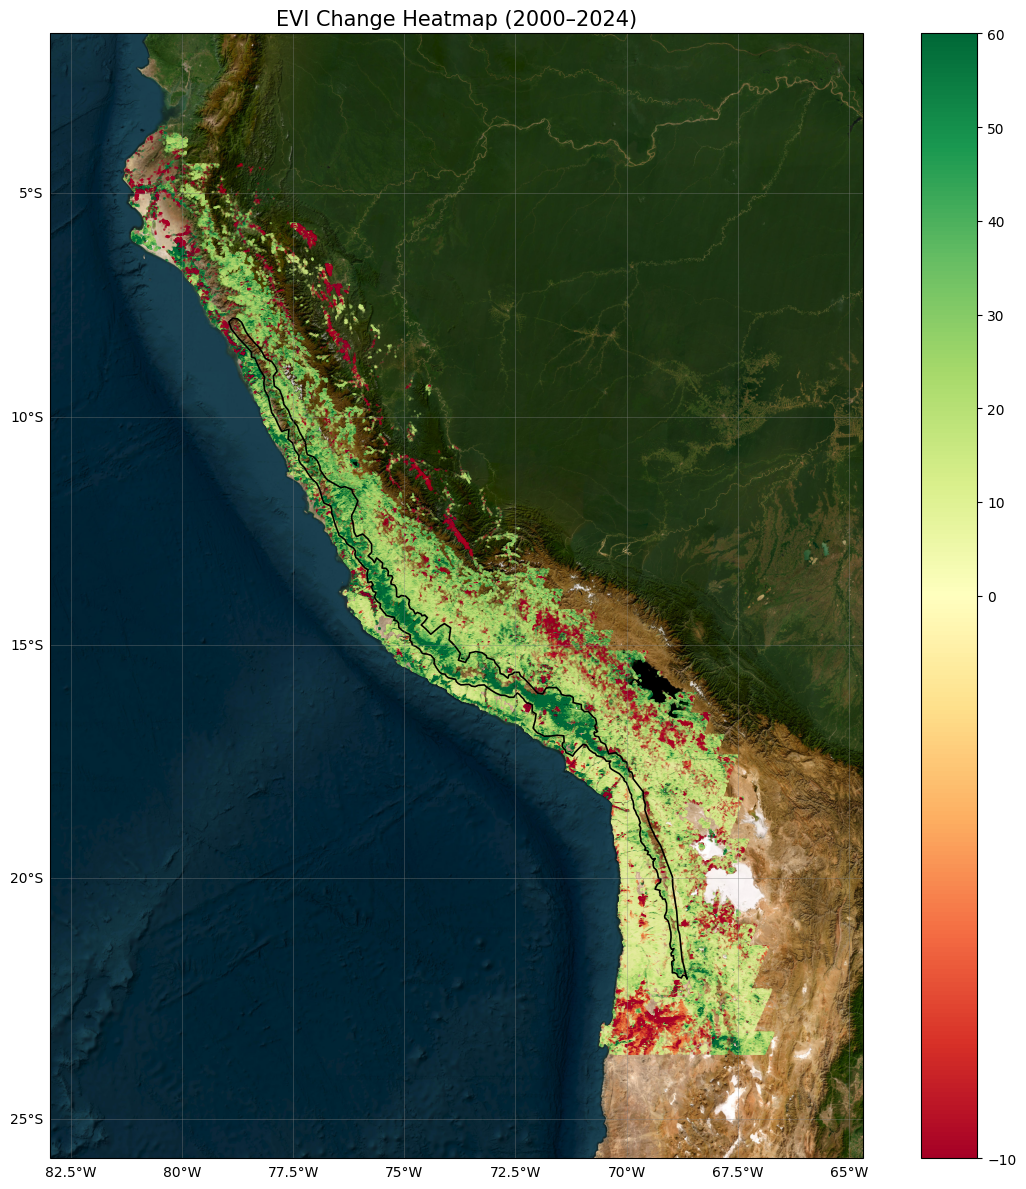

In [ ]:
gdf = gpd.GeoDataFrame(all_features, crs="EPSG:4326")
gdf["delta_evi"] = gdf["delta_evi"].clip(lower=-10, upper=60)

strip_gdf = gpd.read_file(path) # Load greening strip outline

class EsriTiles(OSM): # Define a custom tiler class for basemap imagery
    """
    Custom tile provider class for fetching Esri World Imagery basemap tiles.

    Inherits from `OSM` to utilise the standard tile fetching interface but overrides
    the tile URL template to use Esri's World Imagery tile service.

    Methods:
        _image_url(tile):
            Constructs the URL to retrieve a specific tile from the Esri World Imagery service.
    """
    def __init__(self):
        super().__init__()

    def _image_url(self, tile):
        x, y, z = tile
        return (
            f"https://server.arcgisonline.com/ArcGIS/rest/services/"
            f"World_Imagery/MapServer/tile/{z}/{y}/{x}"
        )

tiler = EsriTiles() # create the tiler
mercator = tiler.crs # set the projection

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={"projection": mercator})
ax.add_image(tiler, 8) # add the basemap image layer with zoom=8

# Reproject both datasets to tile projection
gdf_proj = gdf.to_crs(mercator)
strip_gdf_proj = strip_gdf.to_crs(mercator)

# Plot delta EVI heatmap
norm = TwoSlopeNorm(vmin=-10, vcenter=0, vmax=60)
gdf_proj.plot(
    column="delta_evi",
    cmap="RdYlGn",
    norm=norm,
    markersize=0.1,
    alpha=0.1,
    ax=ax,
    legend=True
)

# Overlay gs outline
strip_gdf_proj.boundary.plot(ax=ax, edgecolor="black", linewidth=1.2)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

ax.set_title("EVI Change Heatmap (2000–2024)", fontsize=15)
plt.tight_layout()
plt.show()

## Getting The Data

### GS, (GS_)BWk, (GS_)BWh, and (GS_)BSk spatially averaged EVI data

Compute and export the average EVI of all pixels in the GS at each time point between 2000 and 2024

In [ ]:
# Import the ROI
roi = ee.FeatureCollection(greening_strip)

# Load MODIS EVI data
evi = ee.ImageCollection("MODIS/061/MOD13Q1") \
    .filterBounds(roi) \
    .filterDate(start_date, end_date) \
    .select("EVI")

# Apply scale factor to EVI (MODIS EVI needs to be scaled by 0.0001)
def scale_evi(img):
    return img.multiply(0.0001).copyProperties(img, img.propertyNames())

scaled_evi = evi.map(scale_evi)

# Load Copernicus Land Cover for 2019 and mask out unwanted classes
lulc = ee.Image("COPERNICUS/Landcover/100m/Proba-V-C3/Global/2019") \
    .select("discrete_classification")

mask = lulc.remap([40, 50, 80], [0, 0, 0], 1).eq(1) # Exclude agriculture (40), urban (50), water (80)

# Mask the EVI data using land cover mask
def apply_mask(img):
    return img.updateMask(mask)

masked_evi = scaled_evi.map(apply_mask)

# Reduce to mean EVI over the ROI for each time step
def extract_mean(img):
    mean_dict = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi.geometry(),
        scale=250,
        maxPixels=1e13
    )
    return ee.Feature(None, {
        'date': img.date().format('YYYY-MM-dd'),
        'evi': mean_dict.get('EVI')
    })

timeseries = masked_evi.map(extract_mean)

# Export the timeseries as a .csv to Google Drive
task = ee.batch.Export.table.toDrive(
    collection=ee.FeatureCollection(timeseries),
    description='GS_EVI_timeseries_masked',
    folder='correlation_data',
    fileFormat='CSV'
)

task.start()

Get the BWk, BWh, BSk, GS_BWk, GS_BWh, and GS_BSk series.

In [ ]:
def export_evi_timeseries_for_zone(class_code, class_name, asset_name, export_description, export_folder="correlation_data"):
    """
    Exports a mean EVI (Enhanced Vegetation Index) time series for a specified K-G climate zone
    within a given ROI, filtered to vegetated land cover types.

    Args:
        class_code (int): K-G climate class code (used to extract specific zone).
        class_name (str): Human readable name of the climate zone (used in export metadata).
        asset_name (str): Earth Engine asset ID for the ROI FeatureCollection.
        export_description (str): Description/name for the export task.
        export_folder (str, optional): Google Drive folder name for export. Default is "correlation_data".
    """
    
    roi = ee.FeatureCollection(asset_name)

    # Load and scale EVI
    evi = ee.ImageCollection("MODIS/061/MOD13Q1") \
        .filterBounds(roi) \
        .filterDate(start_date, end_date) \
        .select("EVI") \
        .map(lambda img: img.multiply(0.0001).copyProperties(img, img.propertyNames()))

    # Land cover mask 
    lulc = ee.Image("COPERNICUS/Landcover/100m/Proba-V-C3/Global/2019") \
        .select("discrete_classification")
    lulc_mask = lulc.remap([40, 50, 80], [0, 0, 0], 1).eq(1)

    # Load K-G zones and get mask for the desired zone
    kg = ee.Image(kg_zones)
    climate_mask = kg.eq(class_code) 
    combined_mask = climate_mask.And(lulc_mask)

    # Apply climate mask to EVI
    def mask_image(img):
        return img.updateMask(combined_mask)

    masked_evi = evi.map(mask_image)

    # Extract mean EVI per image
    def extract_mean(img):
        mean_dict = img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi.geometry(),
            scale=250,
            maxPixels=1e13
        )
        return ee.Feature(None, {
            'date': img.date().format('YYYY-MM-dd'),
            'evi': mean_dict.get('EVI'),
            'zone': class_name
        })

    timeseries = masked_evi.map(extract_mean)

    # Set export description name
    if export_description is None:
        export_description = f"EVI_timeseries_{class_name}"

    # Export to Google Drive as .csv
    export_task = ee.batch.Export.table.toDrive(
        collection=ee.FeatureCollection(timeseries),
        description=export_description,
        folder=export_folder,
        fileFormat='CSV'
    )
    export_task.start()
    print(f"Export task started: {export_description}")

In [ ]:
export_evi_timeseries_for_zone(class_code=4, class_name="BWh", asset_name=study_area, export_description='EVI_timeseries_BWh')
export_evi_timeseries_for_zone(class_code=5, class_name="BWk", asset_name=study_area, export_description='EVI_timeseries_BWk')
export_evi_timeseries_for_zone(class_code=7, class_name="BSk", asset_name=study_area, export_description='EVI_timeseries_BSk')

export_evi_timeseries_for_zone(class_code=4, class_name="BWh", asset_name=greening_strip, export_description='EVI_timeseries_GS_BWh')
export_evi_timeseries_for_zone(class_code=5, class_name="BWk", asset_name=greening_strip, export_description='EVI_timeseries_GS_BWk')
export_evi_timeseries_for_zone(class_code=7, class_name="BSk", asset_name=greening_strip, export_description='EVI_timeseries_GS_BSk')

Export task started: EVI_timeseries_BWh
Export task started: EVI_timeseries_BWk
Export task started: EVI_timeseries_BSk
Export task started: EVI_timeseries_GS_BWh
Export task started: EVI_timeseries_GS_BWk
Export task started: EVI_timeseries_GS_BSk


We need to process the EVI series using the pixel post-processing analysis pipeline done in $\texttt{~/code/notebooks/post_process.ipynb}$ **with the exception of masking and interpolating over snow/ice & clouds**.

Also, note that the climate driver time series will be monthly, so the EVI time series data need to be aggregated to monthly means

In [ ]:
def whittaker_smooth(y, lmbd=10):
    """
    Apply Whittaker smoothing to a 1D time series with optional NaN handling.

    Whittaker smoothing is a penalised least squares approach that balances 
    fidelity to the input data with smoothness by minimising the second-order 
    differences. This implementation also handles missing (NaN) values by 
    applying weights only to observed entries.

    Parameters:
        y (array-like): 
            1D array or list of time series values (can include NaNs).
        lmbd (float, default=10): 
            Smoothing parameter. Higher values increase smoothness by penalising 
            curvature more heavily.

    Returns:
        np.ndarray: 
            Smoothed version of the input series, same shape as `y`.
    """
    y = np.asarray(y)
    n = len(y)
    E = eye(n, format='csc')
    D = E[1:] - E[:-1]  # first order difference matrix
    D2 = D[1:] - D[:-1]  # second order difference matrix
    W = diags((~np.isnan(y)).astype(int), 0, shape=(n, n), format='csc')  # weight matrix
    z = np.copy(y)
    z[np.isnan(z)] = 0  # fill NaNs
    A = W + lmbd * D2.T @ D2
    B = W @ z

    return spsolve(A, B)


def process_averaged_evi(csv_path, frequency=23, lmbd=10, max_iter=10):
    """
    Processes a long-format CSV file of EVI data by smoothing, deseasonalising,
    and aggregating to monthly means.

    Args:
        csv_path (str): Path to the CSV file containing 'date' and 'evi' columns.
        frequency (int, optional): Number of periods in one seasonal cycle (default is 23 for 16-day MODIS).
        lmbd (float, optional): Smoothing parameter for Whittaker filter (default is 10).
        max_iter (int, optional): Maximum number of iterations for iterative fitting (default is 10).

    Returns:
        pandas.Series: Monthly averaged EVI values as a time series with a datetime index.

    Raises:
        ValueError: If required columns ('date', 'evi') are missing from the input CSV.
    """

    df = pd.read_csv(csv_path)
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date")
    df.set_index("date", inplace=True)

    # data in long format so need to resample
    ts = df["evi"].astype(float)
    ts = ts.resample("16D").mean().interpolate() # also interpolate before the seasonal decomposition to remove consecutive NaNs

    decomposition = seasonal_decompose(ts, model="additive", period=frequency)
    evi_cleaned = decomposition.trend + decomposition.resid # retain trend and residuals after seasonal decomposition
    evi_cleaned = evi_cleaned.interpolate(limit_direction='both') # avoid NaNs

    evi_smoothed = whittaker_smooth(evi_cleaned.values, lmbd=lmbd) # first smooth with Whittaker, Ntr

    evi_max_series = np.maximum(evi_cleaned.values, evi_smoothed) # N1

    d = np.abs(evi_cleaned.values - evi_smoothed)
    d_max = np.max(d)
    W = np.where(evi_cleaned.values >= evi_smoothed, 1.0, 1.0 - (d / d_max if d_max != 0 else 0)) # fitting weights

    F_before = np.sum(np.abs(evi_max_series - evi_cleaned.values) * W) # initialise fitting index
    best_evi_max_series = evi_max_series.copy()

    num_iter = 0
    fit = True

    while fit:
        if len(evi_max_series) >= 9: # length of time series must be greater than the window length
            evi_sav_gol = savgol_filter(evi_max_series, window_length=9, polyorder=6) # sav-gol fit
        else:
            evi_sav_gol = evi_max_series.copy()

        evi_max_series = np.maximum(evi_cleaned.values, evi_sav_gol) # Nk
        F_now = np.sum(np.abs(evi_max_series - evi_cleaned.values) * W) # Fk

        if F_now >= F_before or num_iter >= max_iter: # check for convergence or if max iterations is reached
            evi_max_series = best_evi_max_series
            break
        else:
            best_evi_max_series = evi_max_series.copy()
            F_before = F_now
            num_iter += 1

    # Create a Series with the same index as ts
    processed_series = pd.Series(evi_max_series, index=ts.index)

    # Aggregate to monthly means
    monthly_mean = processed_series.resample("ME").mean()

    return monthly_mean

Let's plot these time series

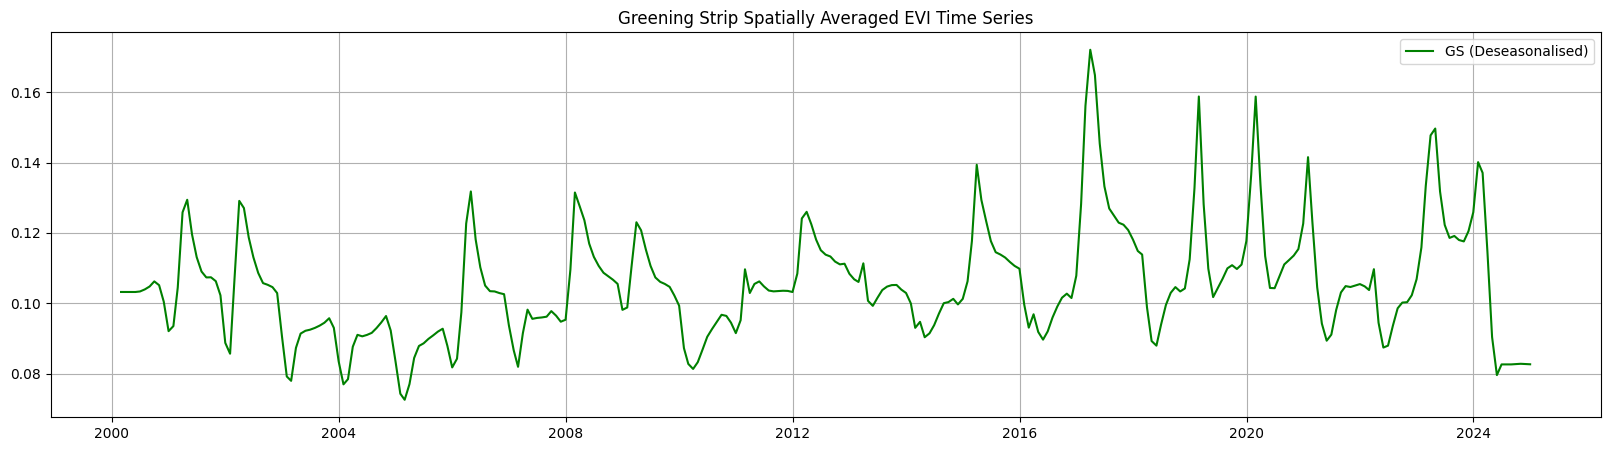

In [ ]:
gs_path = correlation_data+"/GS_EVI_timeseries_masked.csv"
gs = process_averaged_evi(gs_path)

plt.figure(figsize=(20, 5))
plt.plot(gs, label="GS (Deseasonalised)", color="green")
plt.title("Greening Strip Spatially Averaged EVI Time Series")
plt.grid(True)
plt.legend()
plt.show()

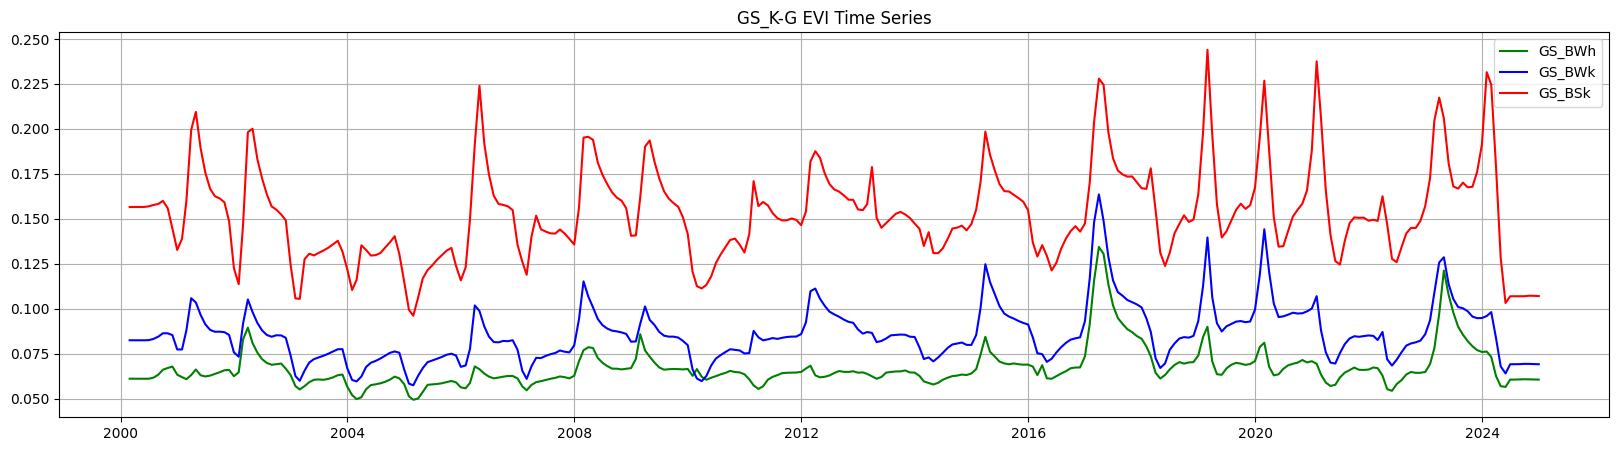

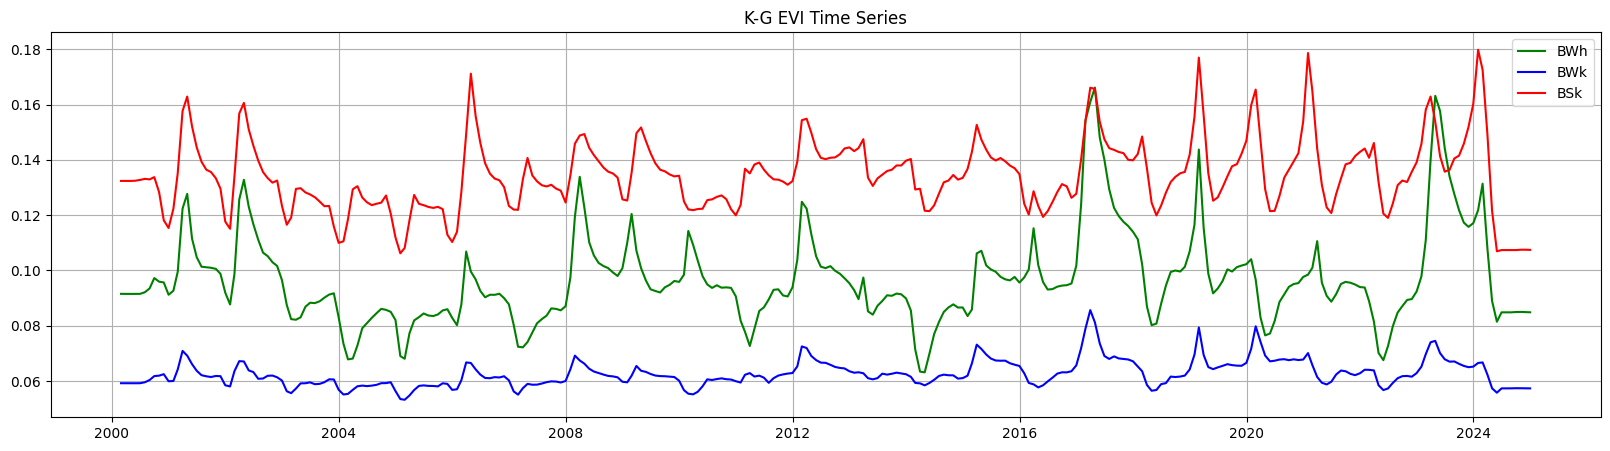

In [ ]:
# set paths
GS_BWh_path = correlation_data+"/EVI_timeseries_GS_BWh.csv"
GS_BWk_path = correlation_data+"/EVI_timeseries_GS_BWk.csv"
GS_BSk_path = correlation_data+"/EVI_timeseries_GS_BSk.csv"

BWh_path = correlation_data+"/EVI_timeseries_BWh.csv"
BWk_path = correlation_data+"/EVI_timeseries_BWk.csv"
BSk_path = correlation_data+"/EVI_timeseries_BSk.csv"

# process time series
GS_BWh = process_averaged_evi(GS_BWh_path)
GS_BWk = process_averaged_evi(GS_BWk_path)
GS_BSk = process_averaged_evi(GS_BSk_path)

BWh = process_averaged_evi(BWh_path)
BWk = process_averaged_evi(BWk_path)
BSk = process_averaged_evi(BSk_path)

# Plot
plt.figure(figsize=(20, 5))
plt.plot(GS_BWh, label="GS_BWh", color="green")
plt.plot(GS_BWk, label="GS_BWk", color="blue")
plt.plot(GS_BSk, label="GS_BSk", color="red")
plt.title("GS_K-G EVI Time Series")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(BWh, label="BWh", color="green")
plt.plot(BWk, label="BWk", color="blue")
plt.plot(BSk, label="BSk", color="red")
plt.title("K-G EVI Time Series")
plt.grid(True)
plt.legend()
plt.show()

### Climate Drivers (SST, CO$_{2}$, and Precipitation) Time Series Data

The Sea Surface Temperature (SST) data was downloaded from (https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download)

The data format is in .grib, so this needs to be processed and saved as a .csv

In [ ]:
# Open .grib file
sst_grib = xr.open_dataset(correlation_data+"/sst.grib", engine="cfgrib")

# Define the bounding box: 6S to 30S and 70W to 80W
lat_bounds = slice(-6, -30)
lon_bounds = slice(-80, -70)

# Subset the SST data over the specified region
sst_region = sst_grib["sst"].sel(latitude=lat_bounds, longitude=lon_bounds)

# Calculate spatial mean (averaging over lat/lon)
sst_mean_timeseries = sst_region.mean(dim=["latitude", "longitude"])

# Convert to a Pandas DataFrame for export
sst_df = sst_mean_timeseries.to_dataframe().reset_index()

# Rename columns to show its Celsius
sst_df.rename(columns={"sst": "sst_C"}, inplace=True)
sst_df["sst_C"] = sst_df["sst_C"] - 273.15
# Save to .csv
sst_df.to_csv(correlation_data+"/sst_timeseries_celsius.csv", index=False)

/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


The CO$_{2}$ data was downloaded from https://gml.noaa.gov/ccgg/trends/gl_data.html

Get the greening strip precipitation data and export as .csv

In [ ]:
# Define CHIRPS dataset and ROI
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY") \
    .filterDate(start_date, end_date)

roi = ee.FeatureCollection(greening_strip)

# Generate monthly mean precipitation features
def create_monthly_features(year):
    """
    Generates monthly mean precipitation features for a given year using CHIRPS data.

    This function creates an Earth Engine `FeatureCollection` with one feature per month,
    each containing the average precipitation over the region of interest (ROI) for that month.

    Args:
        year (int or ee.Number): The year for which monthly precipitation features are computed.

    Returns:
        ee.List: A list of 12 Earth Engine `Feature` objects (one per month) containing:
            - 'date': A string in 'YYYY-MM' format representing the month.
            - 'precip': The mean precipitation over the ROI in millimeters.
    """
    year = ee.Number(year)
    def make_month(month):
        month = ee.Number(month)
        start = ee.Date.fromYMD(year, month, 1)
        end = start.advance(1, 'month')

        monthly = chirps.filterDate(start, end).sum() \
            .set('system:time_start', start.millis())

        mean = monthly.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi,
            scale=5000,
            maxPixels=1e13
        )

        feature = ee.Feature(None, {
            'date': start.format('YYYY-MM'),
            'precip': mean.get('precipitation')
        })
        return feature

    return ee.List.sequence(1, 12).map(make_month)

# Generate all months for all years
years = ee.List.sequence(start_year, end_year)
months = years.map(create_monthly_features).flatten()

# Export to Drive
export = ee.batch.Export.table.toDrive(
    collection=ee.FeatureCollection(months),
    description='CHIRPS_monthly_precip_GS',
    folder='correlation_data',
    fileFormat='CSV'
)
export.start()

Get the greening strip and climate zones precipitation data and export as .csv.

In [ ]:
def export_monthly_chirps_for_zone(zone_name, class_value, roi_asset, kg_asset=kg_zones, export_description=None, export_folder="correlation_data"):
    """
    Exports a time series of monthly mean CHIRPS precipitation values for a specific K-G climate zone 
    within a user-defined region of interest (ROI), clipped to a greening strip.

    This function generates a `FeatureCollection` where each feature represents one month and contains:
        - the month (in "YYYY-MM" format),
        - the average precipitation (mm) over the specified region and zone,
        - the name of the climate zone.

    Args:
        zone_name (str): Human readable name for the K-G class (e.g., "BWk").
        class_value (int): Numeric class code corresponding to a K-G zone in the raster.
        roi_asset (str): Earth Engine asset ID for the FeatureCollection defining the greening strip or ROI.
        kg_asset (str, optional): Earth Engine asset ID for the K-G classification image. Defaults to `kg_zones`.
        export_description (str, optional): Description for the export task. If None, a default is generated.
        export_folder (str, optional): Google Drive folder where the exported CSV will be saved.

    Global Dependencies:
        - `start_date` and `end_date`: Globally defined date strings (e.g., "2001-01-01").
        - `start_year` and `end_year`: Integer values specifying the time range to export.
        - `ee`: The Earth Engine Python API must be initialised.
        - `chirps`: Refers to the CHIRPS daily precipitation collection from UCSB/CHG.

    Output:
        Starts an Earth Engine batch export task to Google Drive with monthly precipitation values in CSV format.
    """
    # Load gs and K-G map
    greening_strip = ee.FeatureCollection(roi_asset)
    kg = ee.Image(kg_asset)

    # Load CHIRPS daily precipitation
    chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY") \
        .filterDate(start_date, end_date)

    # Create mask for current KG zone within ROI
    zone_mask = kg.eq(class_value).selfMask()
    zone_within_strip = zone_mask.clip(greening_strip.geometry())

    # Generate monthly mean precipitation features
    def create_monthly_features(year):
        year = ee.Number(year)

        def make_month(month):
            month = ee.Number(month)
            start = ee.Date.fromYMD(year, month, 1)
            end = start.advance(1, 'month')

            monthly_mean = chirps.filterDate(start, end).sum() \
                .updateMask(zone_within_strip) \
                .set('system:time_start', start.millis())

            reduced = monthly_mean.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=greening_strip.geometry(),
                scale=5000,
                maxPixels=1e13
            )

            return ee.Feature(None, {
                'date': start.format('YYYY-MM'),
                'precip': reduced.get('precipitation'),
                'zone': zone_name
            })

        return ee.List.sequence(1, 12).map(make_month)

    # Get full monthly time series
    years = ee.List.sequence(start_year, end_year)
    monthly_features = years.map(create_monthly_features).flatten()
    feature_collection = ee.FeatureCollection(monthly_features)

    # Export description to Drive
    if export_description is None:
        export_description = f"CHIRPS_monthly_precip_{zone_name}"

    task = ee.batch.Export.table.toDrive(
        collection=feature_collection,
        description=export_description,
        folder=export_folder,
        fileFormat='CSV'
    )
    task.start()
    print(f"Export started: {export_description}")

In [ ]:
export_monthly_chirps_for_zone("BWh", 4, roi_asset=greening_strip, export_description="CHIRPS_monthly_precip_GS_BWh")
export_monthly_chirps_for_zone("BWk", 5, roi_asset=greening_strip, export_description="CHIRPS_monthly_precip_GS_BWk")
export_monthly_chirps_for_zone("BSk", 7, roi_asset=greening_strip, export_description="CHIRPS_monthly_precip_GS_BSk")

export_monthly_chirps_for_zone("BWh", 4, roi_asset=study_area, export_description="CHIRPS_monthly_precip_BWh")
export_monthly_chirps_for_zone("BWk", 5, roi_asset=study_area, export_description="CHIRPS_monthly_precip_BWk")
export_monthly_chirps_for_zone("BSk", 7, roi_asset=study_area, export_description="CHIRPS_monthly_precip_BSk")

Let's plot these time series

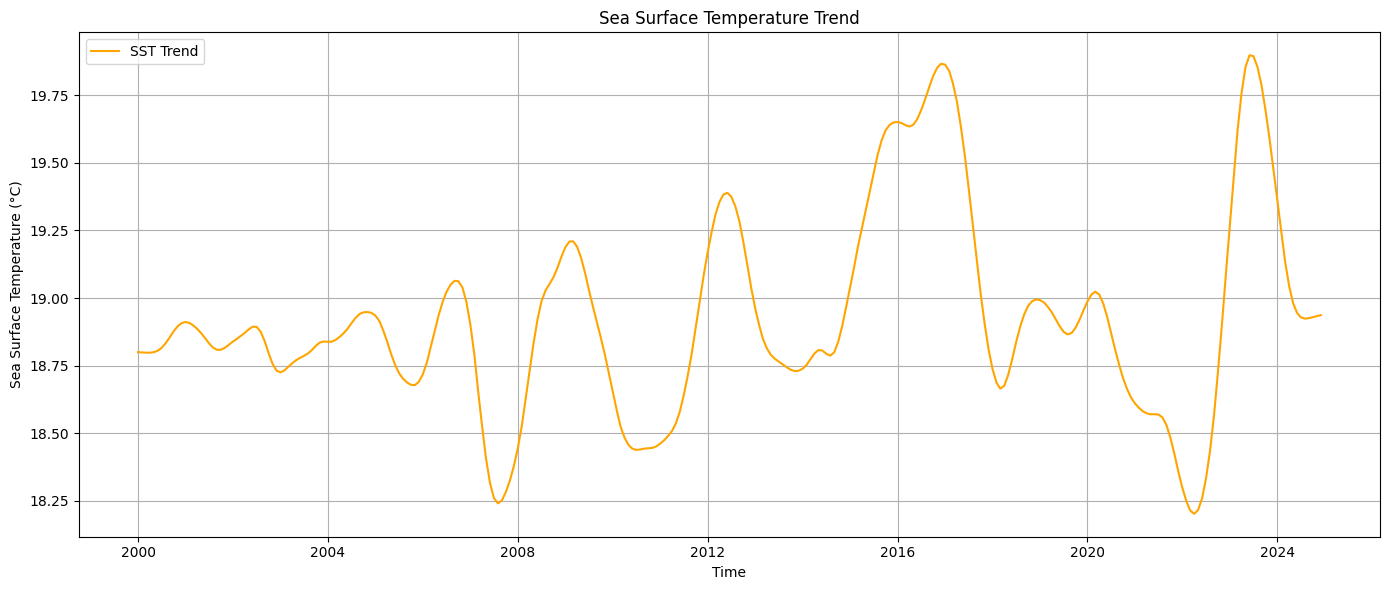

In [ ]:
# Load SST data
sst_df = pd.read_csv(correlation_data+"/sst_timeseries_celsius.csv")

sst_df['time'] = pd.to_datetime(sst_df['time'])
sst_df = sst_df.set_index('time')

# Interpolate missing values
sst_df['sst_C'] = sst_df['sst_C'].interpolate(method='time', limit_direction='both')

# Decompose time series to extract trend 
sst_decomp = seasonal_decompose(sst_df['sst_C'], model='additive', period=12)
sst_df['trend'] = sst_decomp.trend.interpolate(method='time', limit_direction='both')
sst = whittaker_smooth(sst_df['trend'], lmbd=5)

plt.figure(figsize=(14,6))
plt.plot(sst_df.index, sst, label='SST Trend', color='orange')
plt.xlabel('Time')
plt.ylabel('Sea Surface Temperature (°C)')
plt.title('Sea Surface Temperature Trend')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

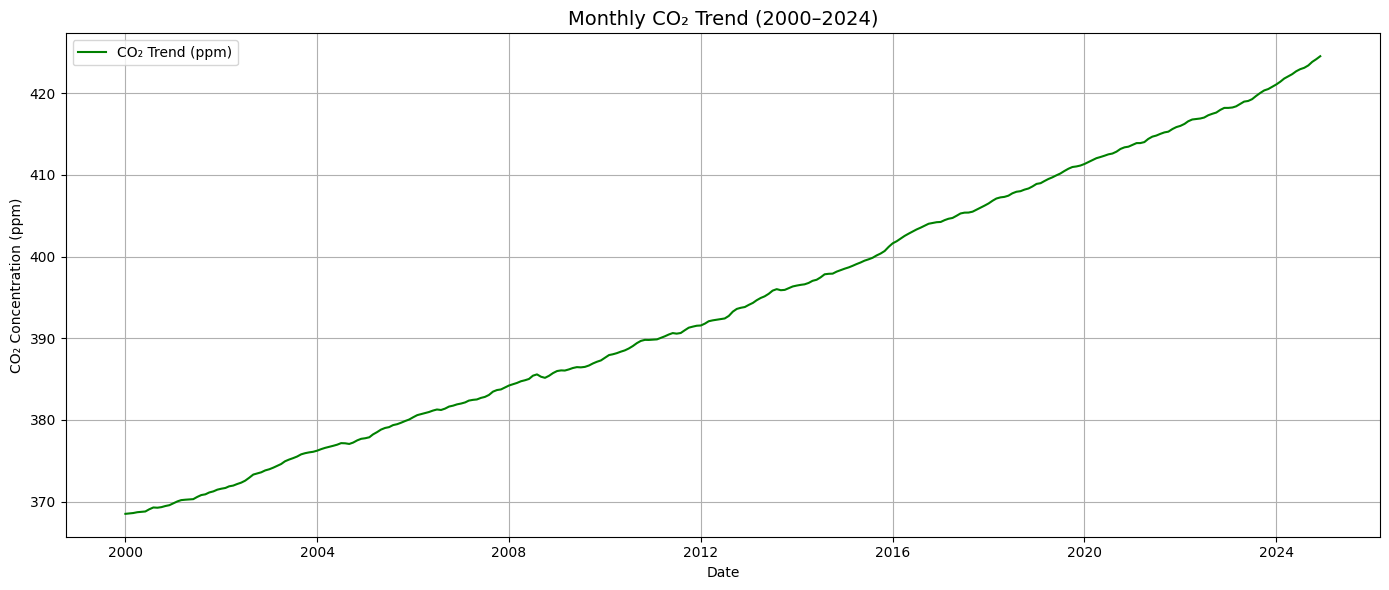

In [ ]:
# Load CO2 .csv file
co2_df = pd.read_csv(correlation_data+"/co2.csv")

# Filter 2000–2024
co2_df = co2_df[(co2_df['year'] >= 2000) & (co2_df['year'] <= 2024)]

co2_df['date'] = pd.to_datetime(dict(year=co2_df.year, month=co2_df.month, day=1))
co2_df = co2_df.set_index('date')

# Use 'trend' column (no seasonality)
co2_monthly = co2_df[['trend']]

# Plot the trend
plt.figure(figsize=(14, 6))
plt.plot(co2_monthly.index, co2_monthly['trend'], label='CO$_{2}$ Trend (ppm)', color='green')

plt.title('Monthly CO$_{2}$ Trend (2000–2024)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('CO$_{2}$ Concentration (ppm)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def load_trend_component(path, label=None, colour=None):
    """
    Loads a time series CSV file of monthly precipitation data, interpolates missing values, 
    performs seasonal decomposition, and returns the trend component along with metadata.

    This function is typically used for preparing time series trend components for visualisation or analysis.

    Args:
        path (str): Path to the CSV file containing the precipitation time series.
                    The CSV must include at least the columns: 'date' and 'precip'.
        label (str, optional): Optional custom label for the trend line (e.g., for plotting).
                               If not provided, the function will generate a label from the 'zone' column if available.
        colour (str, optional): Optional colour code or name (used when plotting). Returned unmodified.

    Returns:
        tuple:
            - pd.DatetimeIndex: The time index of the series.
            - pd.Series: The interpolated trend component of the precipitation series.
            - str: A label for the series.
            - str: The passed colour value (can be None).
    """
    df = pd.read_csv(path, parse_dates=['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)

    # Interpolate missing values 
    df['precip'] = df['precip'].interpolate(method='time', limit_direction='both')

    # Decompose and extract the trend
    decomposition = seasonal_decompose(df['precip'], model='additive', period=12) # period=12 since it is monthly data
    trend = decomposition.trend.interpolate(method='time', limit_direction='both')

    if label is None:
        label = f"Precipitation ({df['zone'].iloc[0]})" if 'zone' in df.columns else "Precipitation"

    return df.index, trend, label, colour

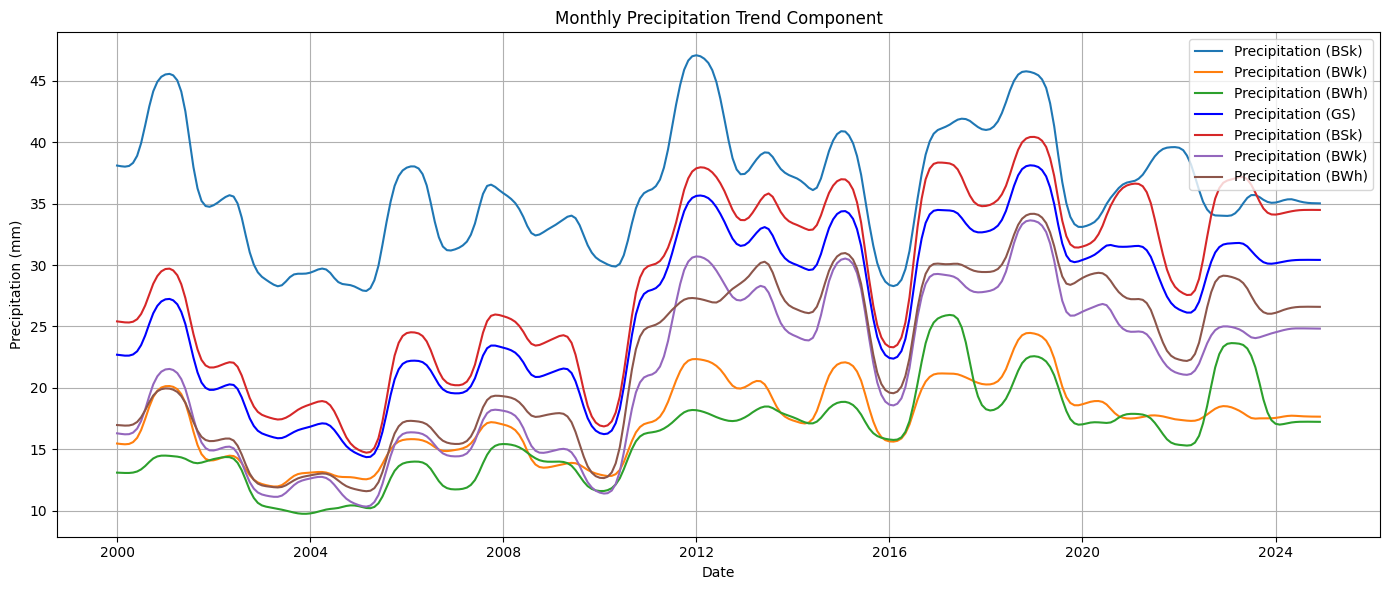

In [ ]:
# File list
files = [
    (correlation_data+'/CHIRPS_monthly_precip_BSk.csv', None, None),
    (correlation_data+'/CHIRPS_monthly_precip_BWk.csv', None, None),
    (correlation_data+'/CHIRPS_monthly_precip_BWh.csv', None, None),
    (correlation_data+'/CHIRPS_monthly_precip_GS.csv', "Precipitation (GS)", 'blue'),
    (correlation_data+'/CHIRPS_monthly_precip_GS_BSk.csv', None, None),
    (correlation_data+'/CHIRPS_monthly_precip_GS_BWk.csv', None, None),
    (correlation_data+'/CHIRPS_monthly_precip_GS_BWh.csv', None, None),
]

# Dictionary to store each time series by file name 
precip_series_dict = {}

plt.figure(figsize=(14, 6))

for path, label, colour in files:
    dates, trend, label, colour = load_trend_component(path, label, colour)

    # Generate variable name based on filename
    base_name = os.path.splitext(os.path.basename(path))[0]
    trend = whittaker_smooth(trend.values, lmbd=5)
    # Store in dictionary
    precip_series_dict[base_name] = pd.Series(trend, index=dates)

    # Plot trend
    plt.plot(dates, trend, label=label, color=colour)

plt.title('Monthly Precipitation Trend Component')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Now Calculate The Correlations

In [ ]:
def lagged_correlation(x, y, max_lag):
    """
    Computes the Spearman rank correlation between two time series at different lags and returns
    the lag with the highest absolute correlation.

    For each lag in the range [-max_lag, max_lag], the function shifts one series relative to the other,
    calculates the correlation over overlapping valid (non-NaN) data points, and identifies the lag 
    that produces the strongest correlation in absolute terms.

    Args:
        x (array-like): First time series data array.
        y (array-like): Second time series data array.
        max_lag (int): Maximum lag (positive integer) to shift the series forward or backward.

    Returns:
        tuple:
            best_corr (float or None): Spearman correlation coefficient at the best lag found.
                                       None if no valid correlation could be computed.
            best_lag (int): Lag value (between -max_lag and max_lag) at which the highest absolute correlation occurs.
    """
    best_corr = None
    best_lag = 0

    x = np.asarray(x, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)

    for lag in range(-max_lag, max_lag + 1): # iterates through different lags
        if lag > 0: # Shift y later in time
            x_lagged = x[:-lag]
            y_aligned = y[lag:]
        elif lag < 0: # Shift y earlier in time
            x_lagged = x[-lag:]
            y_aligned = y[:lag]
        else: # No shift at lag 0
            x_lagged = x
            y_aligned = y

        if len(x_lagged) != len(y_aligned): # Skip if misaligned
            continue

        mask = ~np.isnan(x_lagged) & ~np.isnan(y_aligned) # Only keep valid data, and skip if too little data left
        if np.sum(mask) < 2:
            continue

        corr, _ = spearmanr(x_lagged[mask], y_aligned[mask]) # Compute Spearman rank correlation between the time series

        if best_corr is None or abs(corr) > abs(best_corr): # Keep the correlation with the highest absolute strength
            best_corr = corr
            best_lag = lag

    return best_corr, best_lag

Find the Spearman correlations between each series and store it in a dataframe

In [ ]:
# Define the EVI time series 
evi_series = {
    "BWh": BWh,
    "BWk": BWk,
    "BSk": BSk,
    "GS": gs,
    "GS_BWh": GS_BWh,
    "GS_BWk": GS_BWk,
    "GS_BSk": GS_BSk
}

results = []

for region_name, evi_df in evi_series.items():
    evi = evi_df.dropna().values.flatten()

    # Get the corresponding precipitation, sst, co2 series
    if region_name == "GS":
        precip_key = f"CHIRPS_monthly_precip_GS"
    elif region_name.startswith("GS_"):
        precip_key = f"CHIRPS_monthly_precip_{region_name}"
    else:
        precip_key = f"CHIRPS_monthly_precip_{region_name}"

    precip = precip_series_dict.get(precip_key, pd.Series()).dropna().values
    sst_vals = sst_df['trend'].dropna().values
    co2_vals = co2_monthly["trend"].dropna().values

    # Truncate to length of EVI data
    precip = precip[1:]
    sst_vals = sst_vals[1:]
    co2_vals = co2_vals[1:]

    # Calculate correlations
    precip_corr, _ = lagged_correlation(evi, precip, max_lag=1)
    sst_corr, _ = lagged_correlation(evi, sst_vals, max_lag=12)
    co2_corr, _ = lagged_correlation(evi, co2_vals, max_lag=12)

    results.append({
        "Region": region_name,
        "Precipitation": precip_corr,
        "SST": sst_corr,
        "Global CO2": co2_corr
    })

# Make DataFrame
correlation_df = pd.DataFrame(results)

correlation_df

,Region,Precipitation,SST,Global CO2
0,BWh,0.386341,0.460102,0.206878
1,BWk,0.596819,0.434495,0.470777
2,BSk,0.409417,0.289053,0.319683
3,GS,0.512684,0.433738,0.355380
4,GS_BWh,0.500515,0.447544,0.433601
5,GS_BWk,0.550290,0.464842,0.361726
6,GS_BSk,0.450408,0.382997,0.242507


Let's get some plots of the spatially averaged GS EVI time series and the climate drivers

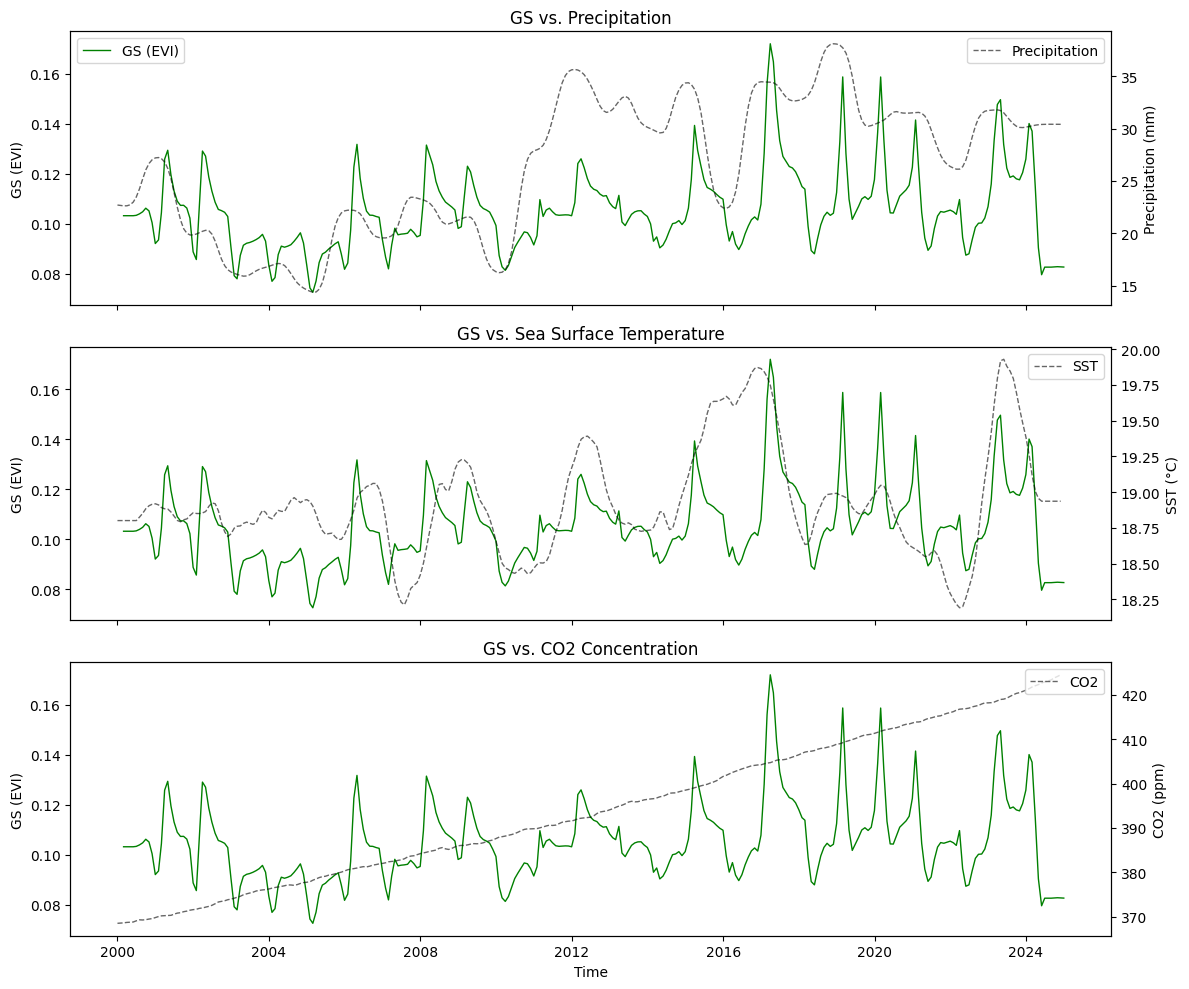

In [ ]:
gs_precip = precip_series_dict.get("CHIRPS_monthly_precip_GS", pd.Series()).dropna()
sst = sst_df['trend']
co2 = co2_monthly["trend"].dropna()

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), sharex=True)

# GS vs Precipitation
ax1 = axes[0]
ax1.plot(gs.index, gs.values, color='green', label="GS (EVI)", linewidth=1)
ax1.set_ylabel("GS (EVI)")
ax1.tick_params(axis='y')

ax1.legend(loc='upper left')

ax1b = ax1.twinx()
line1b, = ax1b.plot(gs_precip.index, gs_precip.values, color='black', label="Precipitation", linewidth=1, ls='--', alpha=0.6)
ax1b.set_ylabel("Precipitation (mm)")
ax1b.tick_params(axis='y')
ax1.set_title("GS vs. Precipitation")

# Add legend for secondary axis
ax1b.legend(loc='upper right')

# GS vs SST 
ax2 = axes[1]
ax2.plot(gs.index, gs.values, color='green', linewidth=1) 
ax2.set_ylabel("GS (EVI)")
ax2.tick_params(axis='y')

ax2b = ax2.twinx()
line2b, = ax2b.plot(sst.index, sst.values, color='black', label="SST", linewidth=1, ls='--', alpha=0.6)
ax2b.set_ylabel("SST (°C)")
ax2b.tick_params(axis='y')
ax2.set_title("GS vs. Sea Surface Temperature")

# Add legend for SST
ax2b.legend(loc='upper right')

# GS vs CO2
ax3 = axes[2]
ax3.plot(gs.index, gs.values, color='green', linewidth=1) 
ax3.set_ylabel("GS (EVI)")
ax3.tick_params(axis='y')

ax3b = ax3.twinx()
line3b, = ax3b.plot(co2.index, co2.values, color='black', label="CO2", linewidth=1, ls='--', alpha=0.6)
ax3b.set_ylabel("CO2 (ppm)")
ax3b.tick_params(axis='y')
ax3.set_title("GS vs. CO2 Concentration")

# Add legend for CO2
ax3b.legend(loc='upper right')

# Set shared x label
ax3.set_xlabel("Time")

plt.tight_layout()
plt.show()